АЗСИИ

ББМО-01-22

Практика №4

Котюкова Виктория Олеговна, Вариант №11

Устанавливаем необхомый пакет apt для работы.

In [25]:
!pip install adversarial-robustness-toolbox

Загружаем необходимые библиотеки.

In [26]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD

Загружаем датасет.

In [27]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Случайная выборка
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

Выполняем предобработку данных.

In [28]:
# Отравленные данные
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Предобработка данных

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

Напишем функцию create_model().

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

def create_model():
    # Определение архитектуры модели
    model = Sequential()

    # Сверточные слои
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))

    # Слой пулинга
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout слой
    model.add(Dropout(0.25))

    # Выравнивающий слой
    model.add(Flatten())

    # Полносвязные слои
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    # Компиляция модели
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

Скомпилируем модель.

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Создадим атаку.

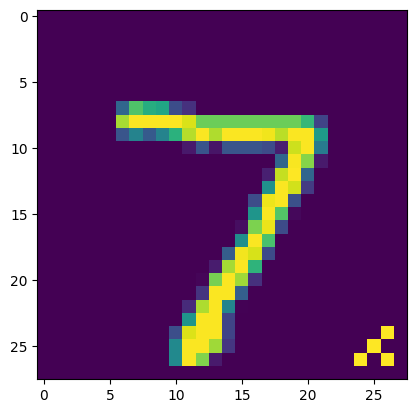

In [31]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)
plt.imshow(pdata[0].squeeze())

Определяем целевой класс атаки.

In [32]:
targets = to_categorical([9], 10)[0]

Создаем модель.

In [33]:
model = KerasClassifier(create_model())
proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Выполняем атаку.

In [35]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(), target=targets,pp_poison=percent_poison, norm=2, eps=5, eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Создаем отравленные примеры данных.

1062
Label: 9


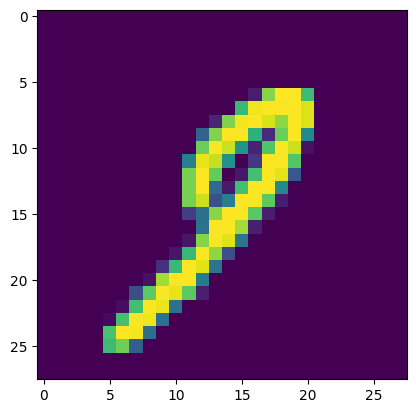

In [36]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]

print(len(poisoned))

idx = 0
plt.imshow(poisoned[idx].squeeze())
print(f"Label: {np.argmax(poisoned_labels[idx])}")

Обучаем модель на отравленных данных.

In [37]:
model.fit(pdata, plabels, nb_epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 124us/sample - loss: 0.5553 - accuracy: 0.8238
Epoch 2/10
10000/10000 [==============================] - 1s 97us/sample - loss: 0.1628 - accuracy: 0.9497
Epoch 3/10
10000/10000 [==============================] - 1s 89us/sample - loss: 0.0956 - accuracy: 0.9703
Epoch 4/10
10000/10000 [==============================] - 1s 84us/sample - loss: 0.0682 - accuracy: 0.9800
Epoch 5/10
10000/10000 [==============================] - 1s 85us/sample - loss: 0.0490 - accuracy: 0.9842
Epoch 6/10
10000/10000 [==============================] - 1s 84us/sample - loss: 0.0391 - accuracy: 0.9877
Epoch 7/10
10000/10000 [==============================] - 1s 83us/sample - loss: 0.0302 - accuracy: 0.9904
Epoch 8/10
10000/10000 [==============================] - 1s 84us/sample - loss: 0.0282 - accuracy: 0.9904
Epoch 9/10
10000/10000 [==============================] - 1s 84us/sample - loss: 0.0230 - accuracy: 0.9925
Epoch 10/10
1

Осуществляем тест на чистой модели.


Clean test set accuracy: 98.09%


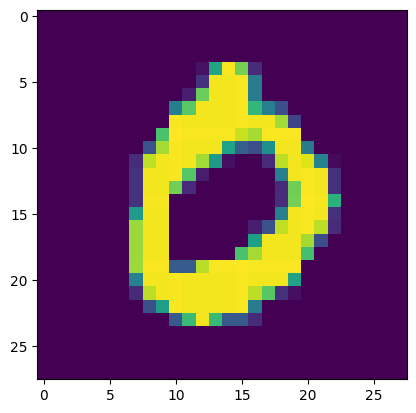

Prediction: 0


In [39]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]
clean_acc = clean_correct / clean_total

print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Отразим, как отравленная модель классифицирует чистую модель
c = 0 # class to display
i = 0 # image of the class to display
c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays
plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

Получаем результаты атаки на модель.


Poison test set accuracy: 3.35%


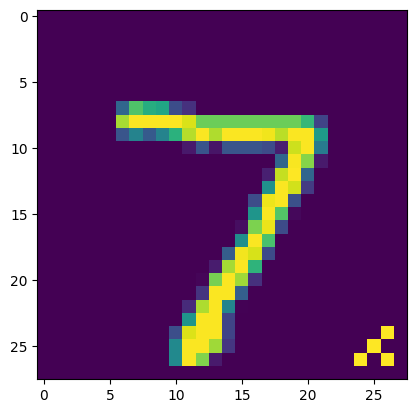

Prediction: 9


In [40]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])
poison_preds = np.argmax(model.predict(px_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(y_test[not_target],
axis=1))
poison_total = poison_preds.shape[0]
poison_acc = poison_correct / poison_total

print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c

print("Prediction: " + str(poison_preds[c]))